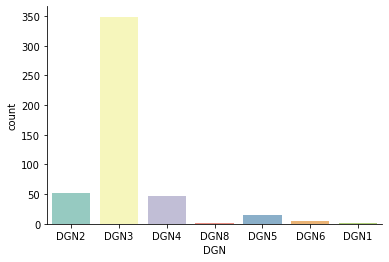

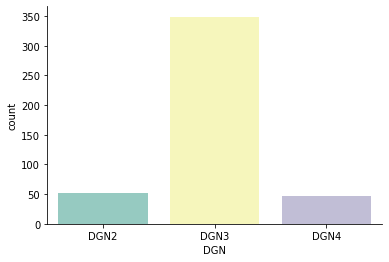

In [1]:
%run 'preprocessing/preprocessing_v1.1.ipynb'

In [2]:
import os 
import time 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np 
import pandas as pd
import seaborn as sns 
sns.set_style('white')
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow as tf 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # for gradient warning (variables are still updated, therefore supressing is fine)
import tensorflow_probability as tfp 
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input
from tensorflow.keras.losses import Loss
import scipy
from ks2d2s import ks2d2s

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# sns.set_palette('viridis')
sns.color_palette('cubehelix')

[(0.10231025194333628, 0.13952898866828906, 0.2560120319409181),
 (0.10594361078604106, 0.3809739011595331, 0.27015111282899046),
 (0.4106130272672762, 0.48044780541672255, 0.1891154277778484),
 (0.7829183382530567, 0.48158303462490826, 0.48672451968362596),
 (0.8046168329276406, 0.6365733569301846, 0.8796578402926125),
 (0.7775608374378459, 0.8840392521212448, 0.9452007992345052)]

### Define prior distribution

In [3]:
def get_prior(num_modes, latent_dim):
    
    mixture_distribution = tfd.Categorical(probs=[1./num_modes] * num_modes)
    components_distribution = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal((num_modes, latent_dim))),
                                                        scale_diag=tfp.util.TransformedVariable(tf.ones((num_modes,latent_dim)),
                                                                                               bijector=tfb.Softplus())
                                                        )
    prior = tfd.MixtureSameFamily(mixture_distribution,
                                  components_distribution
                                 )
    return prior

In [4]:
latent_dim = 2
input_shape = 2

prior = get_prior(num_modes=latent_dim, latent_dim=input_shape) 
print(f'Prior event shape: {prior.event_shape[0]}')
print(f'# of Gaussions: {prior.components_distribution.batch_shape[0]}') 
print(f'Covariance matrix: {prior.components_distribution.name}')

Prior event shape: 2
# of Gaussions: 2
Covariance matrix: MultivariateNormalDiag


### Define KL divergence

In [5]:
# set weight for more emphasis on KLDivergence term rather than reconstruction loss
# average over both samples and batches

def get_KL_regularizer(prior, weight=4.):
    
    regularizer = tfpl.KLDivergenceRegularizer(prior, 
                                        use_exact_kl=False,
                                        test_points_reduce_axis=(),
                                        test_points_fn=lambda q: q.sample(10),
                                        weight=weight
                                        )
    return regularizer

In [6]:
KLDivergence_regularizer = get_KL_regularizer(prior)

### Define the encoder

In [7]:
def get_encoder(input_shape, latent_dim, KL_regularizer):
    
    encoder = Sequential([
        Dense(input_shape=input_shape, units=256, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=32, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, 
                                   activity_regularizer=KL_regularizer),
    ])
    
    return encoder

In [8]:
encoder = get_encoder(input_shape=(input_shape,), latent_dim=latent_dim, KL_regularizer=KLDivergence_regularizer)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8         
Total params: 44,173
Trainable params: 44,173
Non-trainable params: 0
____________________________________________________

### Define the decoder 

In [50]:
def get_decoder(latent_dim):
    
    decoder = Sequential([
        Dense(input_shape=(latent_dim,), units=5, activation='relu'),
        Dense(units=64, activation='relu'),
        Dense(units=128, activation='relu'),
        Dense(units=256, activation='relu'),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim)
    ])
    
    return decoder

In [51]:
decoder = get_decoder(latent_dim)
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_19 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 5)                 1285      
_________________________________________________________________
multivariate_normal_tri_l_2  multiple                  0         
Total params: 43,028
Trainable params: 43,028
Non-trainable params: 0
__________________________________________________

### Connect encoder to decoder 

In [52]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))
vae.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_input (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
_________________________________________________________________
multivariate_normal_tri_l (M multiple                  8   

### Specify the loss function 

In [53]:
# KL divergence is implicity incorporated to the loss function before
# add reconstruction error to loss function 
def reconstruction_error(decoding_dist, x_true):
    return -tf.reduce_mean(decoding_dist.log_prob(x_true))

class custom_reconstruction_error(Loss):
    def call(self, decoding_dist, x_true):
        return -tf.reduce_mean(decoding_dist.log_prob(x_true))

### Selection process

In [ ]:
print(f'# of training samples: {X_train.shape[0]}')
print(f'# of test samples: {X_test.shape[0]}')

In [14]:
y_train.reset_index(drop=True, inplace=True)
X_train['Risk1Yr'] = y_train

In [15]:
X_train[keepdims[1:]] = X_train[keepdims[1:]].astype(np.float32)

In [16]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [17]:
# variances
np.var(X_train),np.var(X_test)

(PRE4    1.0
 PRE5    1.0
 dtype: float32,
 PRE4    0.945721
 PRE5    0.975205
 dtype: float64)

### Compile and fit the model 

In [18]:
X_test.drop(['DGN'], axis=1, inplace=True)

In [19]:
X_train[keepdims[1:]] = X_train[keepdims[1:]].astype(np.float32)
X_test[keepdims[1:]] = X_test[keepdims[1:]].astype(np.float32)

In [20]:
X_train.drop(['DGN', 'Risk1Yr'],axis=1,inplace=True)

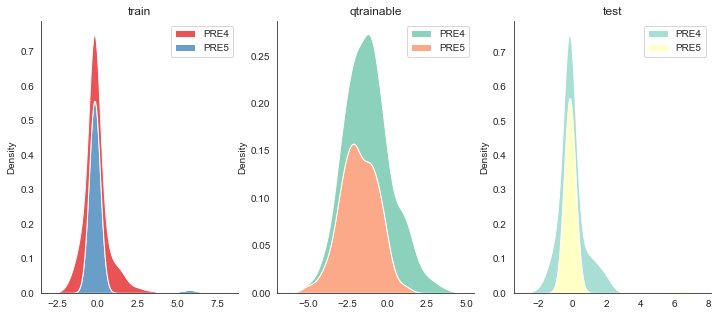

In [27]:
samples = pd.DataFrame(prior.sample(X_train_copy.shape[0]).numpy(), columns=keepdims[1:])
f, axs = plt.subplots(1, 3, figsize=(12,5))
sns.kdeplot(data=pd.DataFrame(X_train_copy.drop(['DGN', 'Risk1Yr'], axis=1), columns=['PRE4','PRE5']), ax=axs[0], multiple="stack", palette='Set1').set_title('train')
sns.kdeplot(data=samples, ax=axs[1], multiple="stack", palette='Set2').set_title('qtrainable')
sns.kdeplot(data=pd.DataFrame(X_test_copy.drop('DGN', axis=1), columns=['PRE4','PRE5']), ax=axs[2], multiple="stack", palette='Set3').set_title('test')
f = f.get_figure()
sns.despine()
f.savefig(os.getcwd() + '/iaf-results/shift-only/p.jpeg')

In [21]:
optimizer = Adam(learning_rate=3e-4)
epochs = 300 
epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: print('\n Epoch {}/{}'.format(epoch+1, epochs, logs),
                                                                       '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                if epoch % 100 == 0 else False
                               )


vae.compile(optimizer=optimizer, loss=reconstruction_error)
history = vae.fit(X_train, 
                  validation_data=(X_test,),
                  epochs=epochs, 
                  batch_size=32,
                  verbose=0,
                  shuffle=True,
                  callbacks=[epoch_callback]
                 )


 Epoch 1/300 
	 loss: 191.7708, val_loss: 181.9105

 Epoch 101/300 
	 loss: 2.6776, val_loss: 2.2991

 Epoch 201/300 
	 loss: 1.4286, val_loss: 1.6062


### Plot training and validation losses 

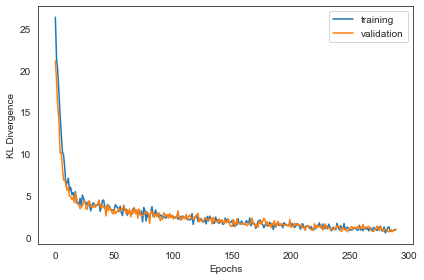

In [22]:
cutoff=10
plt.plot(history.history['loss'][cutoff:], label='training')
plt.plot(history.history['val_loss'][cutoff:], label='validation')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('KL Divergence')
plt.tight_layout()
plt.show()

# Loss function is ELBO maximization
# ELBO maximization is equivalent to KL divergence minimization 

### Sample from the generative model

In [28]:
X_train_sample = decoder(X_train.to_numpy()).sample()
X_train_sample = pd.DataFrame(X_train_sample.numpy(), columns=X_test.columns)

In [29]:
X_train_sample.head()

,PRE4,PRE5
0,-0.311189,0.351092
1,0.048011,-0.515305
2,0.654635,1.031446
3,0.453227,-0.688455
4,1.395011,-0.425473


In [30]:
X_test_sample = decoder(X_test.to_numpy()).sample()
X_test_sample = pd.DataFrame(X_test_sample.numpy(), columns=X_test.columns)
X_test_sample.head()

,PRE4,PRE5
0,-0.515959,0.029718
1,-0.216253,0.788519
2,0.666029,-0.427235
3,1.054357,0.063538
4,-0.527132,0.787624


### Inverse Masked Autoregressive Flow [shift-only]

In [31]:
loc = [X_train_sample[i].mean().astype('float32') for i in list(X_train.columns)]
scale_diag = [X_train_sample[i].std().astype('float32') for i in list(X_train.columns)]

In [32]:
mvn = tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale_diag)
mvn

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [34]:
def masked_autoregressive_flow(hidden_units=[16]):
    made = tfb.AutoregressiveNetwork(params=1, hidden_units=hidden_units)
    return made, tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=lambda y: (made(y)[..., 0], None), 
                                        is_constant_jacobian=True
                                       )

In [40]:
n_samples = X_train.shape[0]

In [41]:
X_train_np = X_train_sample.to_numpy()
X_test_np = X_test_sample.to_numpy()

In [42]:
X_train_np = X_train_np[:,0:2]
X_test_np = X_test_np[:,0:2]

In [43]:
# standardize once again before feeding into network 
scaler.fit(X_train_np)
X_train_np = scaler.transform(X_train_np)
X_test_np = scaler.transform(X_test_np)

In [44]:
X_train = X_train_np.astype(np.float32)
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(32)

X_valid = X_test_np.astype(np.float32)
X_valid = tf.data.Dataset.from_tensor_slices(X_valid)
X_valid = X_valid.batch(32)

In [45]:
num_layers = 4
flow_bijector = []

# set trainable=False for once and for all initialization 
def init_once(x):
    return tf.Variable(x, name='permutation', trainable=False)

made_params = []

for i in range(num_layers):
    made_i, flow_i = masked_autoregressive_flow(hidden_units=[256])
    flow_i = tfb.Invert(flow_i)
    made_params.append(made_i)
    flow_bijector.append(flow_i) 
    flow_bijector.append(tfb.Permute([1,0]))
    
# discard the last permute layer 
flow_bijector = tfb.Chain(list(reversed(flow_bijector[:-1])))

In [46]:
trainable_dist = tfd.TransformedDistribution(distribution=mvn,
                                            bijector=flow_bijector)
# add all made params here
made1 = made_params[0]
made2 = made_params[1]
made3 = made_params[2]
made4 = made_params[3]

trainable_dist._made1 = made1
trainable_dist._made2 = made2
trainable_dist._made3 = made3
trainable_dist._made4 = made4

trainable_dist._made_variables = made1.variables + made2.variables + made3.variables + made4.variables

In [47]:
def make_samples():
    x = mvn.sample(n_samples)
    samples = [x]
    names = [mvn.name]
    for bijector in reversed(trainable_dist.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

In [48]:
num_epochs = 600
opt = tf.keras.optimizers.Adam(3e-4)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in X_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_dist.bijector.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_dist.bijector.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_dist.bijector.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in X_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 100...
Epoch 200...
Epoch 300...
Epoch 400...
Epoch 500...


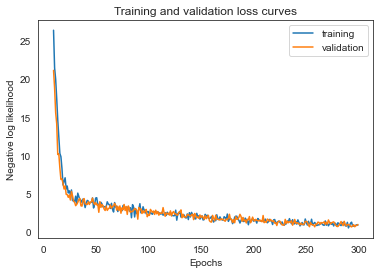

In [49]:
cutoff=10
train_losses = history.history['loss'][cutoff:]
valid_losses = history.history['val_loss'][cutoff:]

plt.plot(np.arange(cutoff, epochs), train_losses, label='training')
plt.plot(np.arange(cutoff, epochs), valid_losses, label='validation')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [58]:
names, samples = make_samples()

In [59]:
def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(20,5))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_train_np), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10)
        z = np.polyfit(X, Y, 1)
        p = np.poly1d(z)
        arr[i].plot(X, p(X), c='green')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

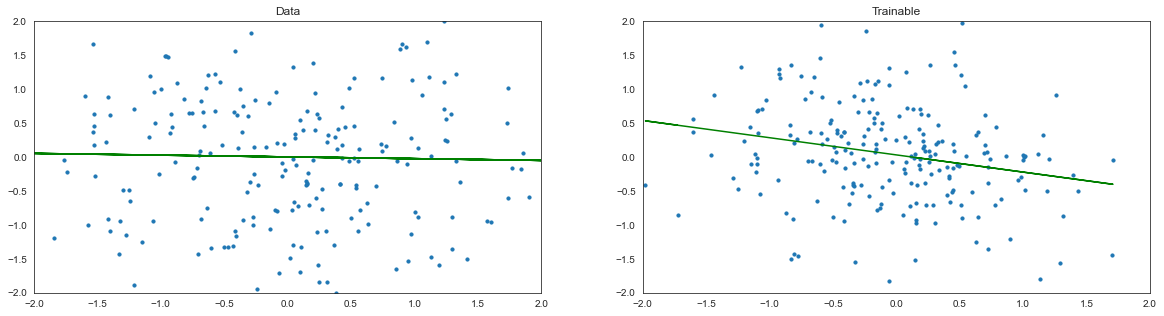

In [60]:
visualize_training_data(samples)

In [61]:
samples = pd.DataFrame(samples[-1].numpy(), columns=['PRE4','PRE5'])
samples.head()

,PRE4,PRE5
0,0.155574,-0.675456
1,0.496507,-0.129078
2,-0.259671,-0.023833
3,0.266134,0.015540
4,0.207862,0.337626


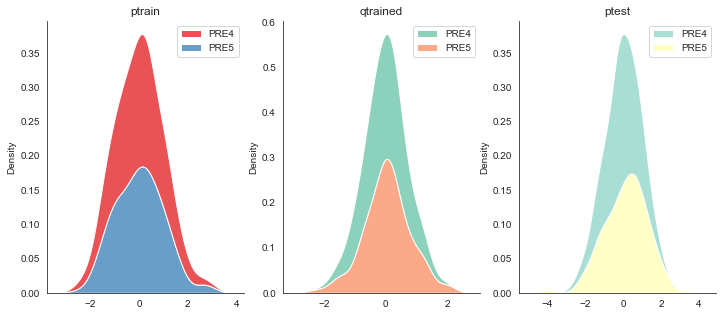

In [62]:
f, axs = plt.subplots(1, 3, figsize=(12,5))
sns.kdeplot(data=pd.DataFrame(X_train_np, columns=['PRE4','PRE5']), ax=axs[0], multiple="stack", palette='Set1').set_title('ptrain')
sns.kdeplot(data=samples, ax=axs[1], multiple="stack", palette='Set2').set_title('qtrained')
sns.kdeplot(data=pd.DataFrame(X_test_np, columns=['PRE4','PRE5']), ax=axs[2], multiple="stack", palette='Set3').set_title('ptest')

f = f.get_figure()
sns.despine()
f.savefig(os.getcwd() + '/iaf-results/shift-only/q.jpeg')

In [65]:
# KS-test
post_sample = trainable_dist.sample(X_train_copy.shape[0]).numpy()

with open('ks-test.txt', 'a') as f:
    f.write('IAF[SHIFT-ONLY] FLOW\n')
    f.write('p-val[training - qtrained] = {}\n'.format(ks2d2s(X_train_np[...,0], X_train_np[...,1], post_sample[...,0], post_sample[...,1])))
    f.write('p-val[testing - qtrained] = {}\n'.format(ks2d2s(X_test_np[...,0], X_test_np[...,1], post_sample[...,0], post_sample[...,1])))
f.close()

### Measure KL Divergence 

In [66]:
# training 
prior_train = mvn.prob(X_train_np).numpy()
learned_train = trainable_dist.prob(X_train_np).numpy()

kl = tf.keras.metrics.KLDivergence()
kl.update_state(prior_train, learned_train)
print(kl.result().numpy())
kl.reset_state()

# testing
prior_test = mvn.prob(X_test_np).numpy()
learned_test = trainable_dist.prob(X_test_np).numpy()

kl = tf.keras.metrics.KLDivergence()
kl.update_state(prior_test, learned_test)
print(kl.result().numpy())
kl.reset_state()

0.23141435
-0.29500332


### Measure Shannon Entropy

In [67]:
# training
cross_entropy = prior_train * np.log(learned_train)
print(-np.ma.masked_invalid(cross_entropy).sum())

# testing
cross_entropy = prior_test * np.log(learned_test)
print(-np.ma.masked_invalid(cross_entropy).sum())

42.479958
39.854866


### Measure Poisson 

In [68]:
# training 
poisson = tf.keras.metrics.Poisson()
poisson.update_state(prior_train, learned_train)
print(poisson.result().numpy())
poisson.reset_state()

# testing 
poisson = tf.keras.metrics.Poisson()
poisson.update_state(prior_test, learned_test)
print(poisson.result().numpy())
poisson.reset_state()

0.29775316
0.27850062


### Measure MAE

In [69]:
# training 
mae = tf.keras.losses.MeanAbsoluteError()
print(mae(prior_train, learned_train).numpy())

# testing
print(mae(prior_test, learned_test).numpy())

0.014020887
0.015920112


### Performance Evaluation

In [70]:
# collect metrics
def _collect(prior_train, prior_test, approx_dist_train, approx_dist_test, results, number_of_run):
    
    # KL training
    kl = tf.keras.losses.KLDivergence()
    results['Kullback-Leibler Divergence'][number_of_run][0] = kl(prior_train, approx_dist_train).numpy()
    # KL testing
    results['Kullback-Leibler Divergence'][number_of_run][1] = kl(prior_test, approx_dist_test).numpy()
    
    # Cross Entropy training
    ce = tf.keras.losses.CategoricalCrossentropy()
    results['Cross Entropy'][number_of_run][0] = ce(prior_train, approx_dist_train).numpy()
    # Cross Entropy testing
    results['Cross Entropy'][number_of_run][1] = ce(prior_test, approx_dist_test).numpy()
    
    # MAE training 
    mae = tf.keras.losses.MeanAbsoluteError()
    results['Mean Absolute Error'][number_of_run][0] = mae(prior_train, approx_dist_train).numpy()
    # MAE testing
    results['Mean Absolute Error'][number_of_run][1] = mae(prior_test, approx_dist_test).numpy()
    
    return results 

# metrics to measure KL, Cross Entropy, Mean Absolute Error
def init_results():
    results = {'Kullback-Leibler Divergence': [[None, None] for _ in range(NUMBER_OF_RUNS)], 
               'Cross Entropy': [[None, None] for _ in range(NUMBER_OF_RUNS)],
               'Mean Absolute Error': [[None, None] for _ in range(NUMBER_OF_RUNS)]
              }
    return results

NUMBER_OF_RUNS = 5
results = init_results()

# generate new observations and measure with the generative model 
def _results(X_train_np, X_test_np, NUMBER_OF_RUNS, results):
    for num in range(NUMBER_OF_RUNS):
        
        prior_train = decoder(X_train_np).sample().numpy()
        prior_test = decoder(X_test_np).sample().numpy()
        
        approx_dist_train = trainable_dist.sample(X_train_np.shape[0]).numpy()
        approx_dist_test = trainable_dist.sample(X_test_np.shape[0]).numpy()
        
        results = _collect(prior_train, prior_test, approx_dist_train, approx_dist_test, results, num)
        
    return results

In [71]:
# convert output of decoder to probabilities 
trial_data = decoder(X_train_np).sample().numpy()
tf.reduce_sum(tf.exp(-trial_data) / tf.reduce_sum(tf.exp(-trial_data), axis=0),axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0000004, 1.       ], dtype=float32)>

In [72]:
# sanity check 
_results(X_train_np, X_test_np, NUMBER_OF_RUNS, results)

{'Kullback-Leibler Divergence': [[4.0252347, 4.4348497],
  [4.25657, 4.8502297],
  [4.569259, 4.54011],
  [4.75732, 4.2916694],
  [4.236284, 4.4985723]],
 'Cross Entropy': [[0.38365406, -0.3406577],
  [0.20952392, -0.17113551],
  [-0.7832368, -0.33374694],
  [-0.3170025, 0.20390992],
  [-0.2702324, 0.9235881]],
 'Mean Absolute Error': [[0.7818614, 0.77304685],
  [0.7675137, 0.8159399],
  [0.7851928, 0.7954239],
  [0.779709, 0.7501689],
  [0.71992046, 0.7761683]]}

### [Pooled Estimate of Common Std. Deviation](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_confidence_intervals/bs704_confidence_intervals5.html)

In [73]:
NUMBER_OF_RUNS = 100
results = init_results()
start_time = time.time()
stats = _results(X_train_np, X_test_np, NUMBER_OF_RUNS, results)
print('Metric sampling in seconds: {sec}'.format(sec=round(time.time()-start_time)))

Metric sampling in seconds: 25


In [74]:
# calculate stds and xbars
stdxbars = {'Kullback-Leibler Divergence': [None, None],
           'Cross Entropy': [None, None],
            'Mean Absolute Error': [None, None]
           }
def _stdxbar(stdxbars, stats):
    for k, v in stats.items(): 
        tensored_samples = tf.convert_to_tensor(v)
        xbars = tf.reduce_mean(tensored_samples, axis=0).numpy()
        xbar_train, xbar_test = xbars[0], xbars[1] 
        stds = tf.math.reduce_std(tensored_samples, axis=0).numpy()
        std_train, std_test = stds[0], stds[1]
        stdxbars[k] = [[xbar_train, std_train], [xbar_test, std_test]]
    return stdxbars

In [75]:
stdxbars = _stdxbar(results, stats)
stdxbars

{'Kullback-Leibler Divergence': [[4.4181395, 0.3791809],
  [4.3578377, 0.37717322]],
 'Cross Entropy': [[0.24275419, 0.6010543], [0.27172673, 0.50797296]],
 'Mean Absolute Error': [[0.777857, 0.029311253], [0.776976, 0.028314998]]}

In [76]:
def _pooled(stdxbars, n):
    poolingstds = {'Kullback-Leibler Divergence': .0,
                  'Cross Entropy': .0,
                   'Mean Absolute Error': .0
                  }
    for k, v in stdxbars.items():
        trainstd = v[0][1]
        teststd = v[1][1]
        estimate = np.sqrt((((n-1)*np.square(trainstd))+((n-1)*np.square(teststd)))/(2*(n-1)))
        
        assertion = False
        try:
            assert .5 <= trainstd/teststd <= 2., '{metric}: One sample variance cannot be the double of the other!'.format(metric=k)
        except AssertionError as e:
            assertion = True
            print(e)
        
        # discard metrics that don't pass sample variance check
        if assertion == False:
            poolingstds[k] = estimate
        else:
            del poolingstds[k]

    return poolingstds

In [77]:
pooled_estimates = _pooled(stdxbars, n=NUMBER_OF_RUNS)
pooled_estimates

{'Kullback-Leibler Divergence': 0.37817838898796613,
 'Cross Entropy': 0.5564633003345476,
 'Mean Absolute Error': 0.028817431056183184}

In [78]:
# calculate 95% CI
def _CI(stdxbars, pooled_estimates, n):
    zval95 = 1.96
    conf_intervals = {'Kullback-Leibler Divergence': .0,
                      'Cross Entropy': .0,
                      'Mean Absolute Error': .0
                     }
    trainxbar = stdxbars['Kullback-Leibler Divergence'][0][0]
    testxbar = stdxbars['Kullback-Leibler Divergence'][1][0]
    mean_diff = testxbar-trainxbar
    estimate = pooled_estimates['Kullback-Leibler Divergence']
    
    upper_bound = np.round(mean_diff+(zval95*estimate*np.sqrt(2/n)),4)
    lower_bound = np.round(mean_diff-(zval95*estimate*np.sqrt(2/n)),4)
    conf_intervals['Kullback-Leibler Divergence'] = [lower_bound, upper_bound]
    
    trainxbar = stdxbars['Cross Entropy'][0][0]
    testxbar = stdxbars['Cross Entropy'][1][0]
    mean_diff = testxbar-trainxbar
    estimate = pooled_estimates['Cross Entropy']

    upper_bound = np.round(mean_diff+(zval95*estimate*np.sqrt(2/n)),4)
    lower_bound = np.round(mean_diff-(zval95*estimate*np.sqrt(2/n)),4)
    conf_intervals['Cross Entropy'] = [lower_bound, upper_bound]

    trainxbar = stdxbars['Mean Absolute Error'][0][0]
    testxbar = stdxbars['Mean Absolute Error'][1][0]
    mean_diff = testxbar-trainxbar
    estimate = pooled_estimates['Mean Absolute Error']
    
    upper_bound = np.round(mean_diff+(zval95*estimate*np.sqrt(2/n)),3)
    lower_bound = np.round(mean_diff-(zval95*estimate*np.sqrt(2/n)),3)
    conf_intervals['Mean Absolute Error'] = [lower_bound, upper_bound]
    
    return conf_intervals

In [79]:
conf_intervals = _CI(stdxbars, pooled_estimates, n=NUMBER_OF_RUNS)
conf_intervals

{'Kullback-Leibler Divergence': [-0.1651, 0.0445],
 'Cross Entropy': [-0.1253, 0.1832],
 'Mean Absolute Error': [-0.009, 0.007]}